### SQLITE
1: Read all the data from bc.csv, how many rows is there ? Columns ?

2: Insert the bc.csv in the sqlite format.

3: In the same db create a new table called tomatch with two variables id_ and rdm_float.

4: In the table tomatch insert observations where the id_ starts from 50k, ends at 10000000 and is only even numbers. rdm_float is a random float for each observation.

5: Do an Inner join between the two tables and compute the different aggregate functions on a column of your choice.

6: How many observations have a radius_mean greater than 15 ? From them how many have a texture_mean greater than 20 ?

7: For each category in diagnosis do the mean of a variable and round it to get only 2 numbers after the comma. Compute the difference between the mean of both groups

8: Change the name of the column "diagnosis" to "label"

9: Add a column named "day" of type DATE.

10: Change the type of the column "area_mean" to int (hint, not possible on sqlite, create a new column)

11: create a new table called tomatch2 exactly the same way as tomatch except you increment id_ by 10.

12: Do an inner join of bc, tomatch and tomatch2 where the radius_mean is greater than 15, and the rdm_float is greater than 0.50 in tomatch AND tomatch2.

### 1: Read all the data from bc.csv, how many rows is there ? Columns ?

In [2]:

import pandas as pd

df = pd.read_csv("C:/Users/Georgiana/Downloads/bc.csv")
print(df.shape) #569 lignes et 33 colonnes
df.head(5)

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### 2: Insert the bc.csv in the sqlite format.

In [1]:
# Je l'ai importé sur DB browser directement.

### 3: In the same db create a new table called tomatch with two variables id_ and rdm_float.

In [28]:

import tqdm
import sqlite3
import pandas as pd

df = pd.read_csv('C:/Users/Georgiana/Downloads/bc.csv')

conn = sqlite3.connect('C:/Users/Georgiana/Downloads/BCbase.db') #importé à partir de DBbrowser
c = conn.cursor()


def create_table_tomatch():
    try:
        c.execute("""CREATE TABLE IF NOT EXISTS tomatch("id_" int PRIMARY KEY, "rdm_float" FLOAT)""")
        conn.commit()
    except Exception as e:
        print(str(e))
        
create_table_tomatch()

### 4: In the table tomatch insert observations where the id_ starts from 50k, ends at 10000000 and is only even numbers. rdm_float is a random float for each observation.

In [29]:

import random as rd
import tqdm
c = conn.cursor()

query = """INSERT INTO tomatch("id_", "rdm_float") VALUES (?, ?)"""
liste_insertion=[]
for i in tqdm.tqdm(range(50000, 10000001, 2)):
    values=(i, rd.random())
    liste_insertion.append(values)
    if len(liste_insertion)==10000:
        c.executemany(query, liste_insertion)
        liste_insertion=[]
conn.commit()        


100%|████████████████████████████████████████████████████████████████████| 4975001/4975001 [00:10<00:00, 495027.61it/s]


 ### 5: Do an Inner join between the two tables and compute the different aggregate functions on a column of your choice.

In [97]:
import sqlite3
conn = sqlite3.connect('C:/Users/Georgiana/Downloads/BCbase.db') 
c = conn.cursor()
c.execute("""SELECT AVG(bc.concavity_worst), SUM(bc.concavity_worst), MIN(bc.concavity_worst), 
       MAX(bc.concavity_worst), COUNT(bc.concavity_worst)
FROM bc
INNER JOIN tomatch ON bc.id = tomatch.id_
""")
docs=c.fetchall()
print(docs)

[(0.2645051851851851, 64.27475999999999, 0.0, 1.17, 243)]


### 6: How many observations have a radius_mean greater than 15 ? From them how many have a texture_mean greater than 20 ?

In [13]:

c.execute( """
SELECT COUNT(*)
FROM bc
WHERE radius_mean > 15 AND texture_mean > 20
""")
docs=c.fetchall()
print(docs)

[(106,)]


### 7: For each category in diagnosis do the mean of a variable and round it to get only 2 numbers after the comma. Compute the difference between the mean of both groups

In [98]:
query = """
SELECT diagnosis,
       ROUND(AVG(concavity_worst), 2) AS mean_concavity_stats,
       (SELECT ROUND(AVG(concavity_worst), 2) FROM bc WHERE diagnosis = 'M') -
       (SELECT ROUND(AVG(concavity_worst), 2) FROM bc WHERE diagnosis = 'B') AS mean_difference
FROM bc
GROUP BY diagnosis
"""

c.execute(query)
results = c.fetchall()
print(results)

# Calcul de la différence moyenne entre 'M' et 'B'
mean_difference_between_M_and_B = results[1][1] - results[0][1]
print("La différence des moyennes est:", round(mean_difference_between_M_and_B, 2))


[('B', 0.17, 0.28), ('M', 0.45, 0.28)]
La différence des moyennes est: 0.28


### 8: Change the name of the column "diagnosis" to "label"

In [20]:
query = """
ALTER TABLE bc
RENAME COLUMN diagnosis TO label
"""
c.execute(query)
conn.commit()

### 9: Add a column named "day" of type DATE.

In [21]:
query = """
ALTER TABLE bc
ADD COLUMN day DATE
"""
c.execute(query)
conn.commit()



### 10: Change the type of the column "area_mean" to int (hint, not possible on sqlite, create a new column)

In [27]:
query_add_column = """
ALTER TABLE bc
ADD COLUMN area_mean_new INTEGER
"""

c.execute(query_add_column)
query_update_column = """
UPDATE bc
SET area_mean_new = CAST(area_mean AS INTEGER)
"""

c.execute(query_update_column)

query_drop_column = """
ALTER TABLE bc
DROP COLUMN area_mean
"""

c.execute(query_drop_column)

query_rename_column = """
ALTER TABLE bc
RENAME COLUMN area_mean_new TO area_mean
"""

c.execute(query_rename_column)
conn.commit()



### 11: Create a new table called tomatch2 exactly the same way as tomatch except you increment id_ by 10.


In [1]:
import tqdm
import sqlite3
import pandas as pd
import random as rd
conn = sqlite3.connect('C:/Users/Georgiana/Downloads/BCbase.db') #importé à partir de DBbrowser
c = conn.cursor()
def create_table_tomatch2():
    try:
        c.execute("""CREATE TABLE IF NOT EXISTS tomatch2("id_" int PRIMARY KEY, "rdm_float" FLOAT)""")
        conn.commit()
    except Exception as e:
        print(str(e))
        
create_table_tomatch2()
query = """INSERT INTO tomatch2("id_", "rdm_float") VALUES (?, ?)"""
liste_insertion=[]
for i in tqdm.tqdm(range(50000, 10000001, 10)):
    values=(i, rd.random())
    liste_insertion.append(values)
    if len(liste_insertion)==10000:
        c.executemany(query, liste_insertion)
        liste_insertion=[]
conn.commit() 



100%|██████████████████████████████████████████████████████████████████████| 995001/995001 [00:01<00:00, 507748.55it/s]


### 12: Do an inner join of bc, tomatch and tomatch2 where the radius_mean is greater than 15, and the rdm_float is greater than 0.50 in tomatch AND tomatch2.

In [9]:
conn = sqlite3.connect('C:/Users/Georgiana/Downloads/BCbase.db') #importé à partir de DBbrowser
c = conn.cursor()
c.execute("""SELECT *
FROM bc
INNER JOIN tomatch ON bc.id = tomatch.id_
INNER JOIN tomatch2 ON bc.id = tomatch2.id_
WHERE bc.radius_mean > 15
  AND tomatch.rdm_float > 0.50
  AND tomatch2.rdm_float > 0.50""")
result=c.fetchall()
conn.commit()
print(result)
  

[(857010, 'M', 18.65, 17.6, 123.7, 0.1099, 0.1686, 0.1974, 0.1009, 0.1907, 0.06049, 0.6289, 0.6633, 4.293, 71.56, 0.006294, 0.03994, 0.05554, 0.01695, 0.02428, 0.003535, 22.82, 21.32, 150.6, 1567, 0.1679, 0.509, 0.7345, 0.2378, 0.3799, 0.09185, None, None, 1076, 857010, 0.7232892425912114, 857010, 0.790780418640991), (884180, 'M', 19.4, 23.5, 129.1, 0.1027, 0.1558, 0.2049, 0.08886, 0.1978, 0.06, 0.5243, 1.802, 4.037, 60.41, 0.01061, 0.03252, 0.03915, 0.01559, 0.02186, 0.003949, 21.65, 30.53, 144.9, 1417, 0.1463, 0.2968, 0.3458, 0.1564, 0.292, 0.07614, None, None, 1155, 884180, 0.519257728911011, 884180, 0.9596308788019965), (888570, 'M', 17.29, 22.13, 114.4, 0.08999, 0.1273, 0.09697, 0.07507, 0.2108, 0.05464, 0.8348, 1.633, 6.146, 90.94, 0.006717, 0.05981, 0.04638, 0.02149, 0.02747, 0.005838, 20.39, 27.24, 137.9, 1295, 0.1134, 0.2867, 0.2298, 0.1528, 0.3067, 0.07484, None, None, 947, 888570, 0.5162032333252067, 888570, 0.9935697533170934), (8911670, 'M', 18.81, 19.98, 120.9, 0.08923, 0

# Questions MySQL
1: How many orders were placed in total?

2: What is the total sales amount?

3: What is the average profit per order?

4: Which customer has placed the most orders?

5: What is the total profit for each product category?

6: What is the average discount percentage?

7: Which region has the highest total sales?

8: How many orders were shipped using each shipping mode?

9: What is the total quantity ordered for each product sub-category?

10: Which product has the highest profit margin?

11: What is the total sales amount for each year?

12: Which customer segment has the highest average sales?

In [10]:
import pandas as pd
import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="root",
  database="m1_ds2e"
)

c = mydb.cursor()

c.execute("SELECT * FROM sample_superstore")

docs = c.fetchall()

columns = [description[0] for description in c.description]
df = pd.DataFrame(docs, columns=columns)

df.head()

,Row ID,Order Priority,Discount,Unit Price,Shipping Cost,Customer ID,Customer Name,Ship Mode,Customer Segment,Product Category,...,Region,State or Province,City,Postal Code,Order Date,Ship Date,Profit,Quantity ordered new,Sales,Order ID
0,18606,Not Specified,0.01,2.88,0.50,2,Janice Fletcher,Regular Air,Corporate,Office Supplies,...,Central,Illinois,Addison,60101,5/28/2012,5/30/2012,1.3200,2,5.90,88525
1,20847,High,0.01,2.84,0.93,3,Bonnie Potter,Express Air,Corporate,Office Supplies,...,West,Washington,Anacortes,98221,7/7/2010,7/8/2010,4.5600,4,13.01,88522
2,23086,Not Specified,0.03,6.68,6.15,3,Bonnie Potter,Express Air,Corporate,Office Supplies,...,West,Washington,Anacortes,98221,7/27/2011,7/28/2011,-47.6400,7,49.92,88523
3,23087,Not Specified,0.01,5.68,3.60,3,Bonnie Potter,Regular Air,Corporate,Office Supplies,...,West,Washington,Anacortes,98221,7/27/2011,7/28/2011,-30.5100,7,41.64,88523
4,23088,Not Specified,0.00,205.99,2.50,3,Bonnie Potter,Express Air,Corporate,Technology,...,West,Washington,Anacortes,98221,7/27/2011,7/27/2011,998.2023,8,1446.67,88523


### 1: How many orders were placed in total?

In [5]:
import mysql.connector

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="root",
    database="m1_ds2e"
)

c = mydb.cursor()
c.execute("""SELECT COUNT( "Order ID") AS total_commandes
FROM sample_superstore""");
result=c.fetchall()
print(result)

[(175,)]


### 2. What is the total sales amount?

In [25]:
c.execute("""SELECT SUM(sales) AS total_sales FROM sample_superstore""")
result = c.fetchall()
print(result)


[(130555.31000000006,)]


### 3.What is the average profit per order?

In [6]:
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="root",
    database="m1_ds2e"
)

c = mydb.cursor()
c.execute("""SELECT `Order ID` , AVG(Profit) AS avg_profit
FROM m1_ds2e.sample_superstore
GROUP BY `Order ID`""")

docs = c.fetchall()
print(docs)

[(88525, 1.32), (88522, 4.56), (88523, 306.6841), (88524, 1388.0523), (88526, 1001.4453), (90193, 4390.3665), (90197, -141.26), (90194, 1045.4673), (90200, 406.7419), (90198, 72.9928), (90199, -252.67759875000002), (90195, 142.7955), (90192, -53.8096), (90196, 23.12), (86838, 185.425125), (86845, -44.54), (86837, -59.82), (86839, 261.8757), (86840, -1.17), (86841, -24.03), (86842, 23.2668), (86843, -174.2696), (86836, 327.68155), (86844, 3.4595), (90033, -6.82), (90034, -96.33), (90031, 314.4813), (90035, 164.48680000000002), (90038, -17.49), (90039, 139.54835), (90032, -114.6399), (90036, -491.73199999999997), (90037, -41.82), (41793, 384.38), (42949, -66.06495), (55269, -41.82), (9895, -6.82), (17860, -96.33), (26887, 172.27274999999997), (50533, -491.73199999999997), (18596, 174.845), (87655, 571.89495), (87660, 83.24), (87669, 353.77216), (87651, -16.802), (87656, 1489.8411), (87662, -23.415), (87663, -88.102), (87657, -10.58), (87666, 677.50343), (87658, 420.984), (87667, 19.4097)

### 4. Which customer has placed the most orders?

In [24]:
import mysql.connector
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="root",
    database="m1_ds2e"
)

c = mydb.cursor()
query = """
     SELECT `Customer Name` , sum(`Quantity ordered new`) AS Quantity_ordered
FROM sample_superstore
GROUP BY `Customer Name` order by Quantity_ordered desc;
"""
c.execute(query)
most_orders_client = c.fetchone()
print(f"Client avec le plus de commandes : {most_orders_client[0]} avec {most_orders_client[1]} unités commandéss.")

Client avec le plus de commandes : Tony Wilkins Winters avec 533 unités commandéss.


### 5: What is the total profit for each product category?

In [15]:
query = """
    SELECT 
        `Product Category`, 
        SUM(Profit) AS Total_Profit
    FROM 
        sample_superstore
    GROUP BY 
        `Product Category`;
"""
c.execute(query)
profit_by_category = c.fetchall()

print("Profit par catégorie de produit :")
for category, profit in profit_by_category:
    print(f"{category}: {profit}")


Profit par catégorie de produit :
Office Supplies: 11605.983540000001
Technology: 10225.340091999999
Furniture: 1976.0725965000036


### 6: What is the average discount percentage?

In [17]:
query = """
    SELECT 
        AVG(Discount) AS Avg_Discount_Percentage
    FROM 
        sample_superstore;
"""
c.execute(query)
avg_discount = c.fetchone()[0]
print(f"Le taux de remise moyen en pourcentage est : {avg_discount * 100:.2f}%")

Le taux de remise moyen en pourcentage est : 4.97%


### 7: Which region has the highest total sales?

In [18]:
query = """
    SELECT 
        `Region`, 
        SUM(Sales) AS Total_Sales
    FROM 
        sample_superstore 
    GROUP BY 
        `Region`
    ORDER BY 
        Total_Sales DESC
    LIMIT 1;
"""
c.execute(query)
region_with_highest_sales = c.fetchone()
print(f"La région avec le total des ventes le plus élevé est : {region_with_highest_sales[0]} avec un total de ventes de {region_with_highest_sales[1]}.")

La région avec le total des ventes le plus élevé est : West avec un total de ventes de 75678.49999999999.


### 8: How many orders were shipped using each shipping mode?

In [23]:
query = """
    SELECT 
        `Ship Mode`, 
        COUNT(DISTINCT `Order ID`) AS Total_Orders_Shipped
    FROM 
        sample_superstore 
    GROUP BY 
        `Ship Mode`;
"""
c.execute(query)
orders_shipped_by_mode = c.fetchall()
print("Nombre de commandes expédiées par mode d'expédition :")
for mode, total_orders_shipped in orders_shipped_by_mode:
    print(f"{mode}: {total_orders_shipped}")

Nombre de commandes expédiées par mode d'expédition :
Delivery Truck: 19
Express Air: 20
Regular Air: 100


### 9:  What is the total quantity ordered for each product sub-category?

In [24]:
query = """
    SELECT 
        `Product Sub-Category`, 
        SUM(`Quantity ordered new`) AS Total_Quantity_Ordered
    FROM 
        sample_superstore 
    GROUP BY 
        `Product Sub-Category`;
"""
c.execute(query)

total_quantity_ordered_by_subcategory = c.fetchall()

print("Quantité totale commandée par sous-catégorie de produit :")
for subcategory, total_quantity_ordered in total_quantity_ordered_by_subcategory:
    print(f"{subcategory}: {total_quantity_ordered}")


Quantité totale commandée par sous-catégorie de produit :
Labels: 171
Pens & Art Supplies: 196
Paper: 286
Scissors, Rulers and Trimmers: 24
Telephones and Communication: 252
Office Machines: 123
Chairs & Chairmats: 166
Appliances: 184
Bookcases: 39
Tables: 50
Envelopes: 46
Office Furnishings: 233
Rubber Bands: 119
Binders and Binder Accessories: 129
Storage & Organization: 121
Copiers and Fax: 5
Computer Peripherals: 69


### 10: Which product has the highest profit margin?

In [8]:
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="root",
    database="m1_ds2e"
)

c = mydb.cursor()
query = """
    SELECT `Product Name` ,(SUM(Profit) / SUM(Sales)) AS profit_margin
FROM sample_superstore
GROUP BY `Product Name` 
ORDER BY profit_margin desc LIMIT 1;
"""
c.execute(query)
product_with_highest_profit_margin = c.fetchone()
print(f"Le produit avec la marge bénéficiaire la plus élevée est : {product_with_highest_profit_margin[0]} avec une marge bénéficiaire de {product_with_highest_profit_margin[1]:.2f}.")


Le produit avec la marge bénéficiaire la plus élevée est : Canon S750 Color Inkjet Printer avec une marge bénéficiaire de 0.69.


### 11:  What is the total sales amount for each year?

In [36]:
query = """
    SELECT 
        RIGHT(`Order Date`, 4) AS Year,
        SUM(Sales) AS Total_Sales
    FROM 
        sample_superstore
    GROUP BY 
        Year;
"""
c.execute(query)

total_sales_by_year = c.fetchall()

print("Montant total des ventes pour chaque année :")
for year, total_sales in total_sales_by_year:
    print(f"Année {year}: {total_sales}$")

Montant total des ventes pour chaque année :
Année 2012: 44893.209999999985$
Année 2010: 25377.779999999995$
Année 2011: 12048.119999999997$
Année 2013: 48236.200000000004$


### 12:  Which customer segment has the highest average sales?

In [38]:
query = """
    SELECT 
        `Customer Segment`,
        AVG(Sales) AS Average_Sales
    FROM 
        sample_superstore
    GROUP BY 
        `Customer Segment`
    ORDER BY 
        Average_Sales DESC
    LIMIT 1;
"""
c.execute(query)

segment_with_highest_average_sales = c.fetchone()
average_sales_rounded = round(segment_with_highest_average_sales[1], 2)
print(f"Le segment de client avec les ventes moyennes les plus élevées est : {segment_with_highest_average_sales[0]} avec une moyenne de ventes de {average_sales_rounded}.")

Le segment de client avec les ventes moyennes les plus élevées est : Small Business avec une moyenne de ventes de 1041.56.


### PostgreSQL
1: What is the average age of the customers?

2: How many customers have defaulted on loans?

3: What is the maximum balance in the account?

4: How many customers have a housing loan?

5: What is the education level of the youngest customer?

6: What is the marital status of the oldest customer?

7: What is the distribution of the months in which customers were last contacted?

8: What is the average duration of contact for customers who have a personal loan?

9: How many customers were previously contacted, and what was the average duration of their last contact?

10: What is the distribution of job types among customers?

11: How many customers have been contacted more than once in the current campaign?

12: What is the success rate of previous marketing campaigns (poutcome) among customers

In [40]:
import pandas as pd
df = pd.read_csv("C:/Users/Georgiana/Downloads/bank_full.csv")
df.columns

Index(['age', 'job', 'marital', 'education', 'default_', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [10]:
import psycopg2

# Connect to PostgreSQL database
conn = psycopg2.connect(dbname="new_db", user="postgres", password="root", host="localhost",  port="5432" )

In [44]:
cur = conn.cursor()

# Define the table schema
table_name = "bank_full"
columns = [
    "age INTEGER",
    "job VARCHAR(100)",
    "marital VARCHAR(20)",
    "education VARCHAR(100)",
    "default_ VARCHAR(10)",
    "balance NUMERIC",
    "housing VARCHAR(10)",
    "loan VARCHAR(10)",
    "contact VARCHAR(100)",
    "day INTEGER",
    "month VARCHAR(20)",
    "duration INTEGER",
    "campaign INTEGER",
    "pdays INTEGER",
    "previous INTEGER",
    "poutcome VARCHAR(100)",
    "y VARCHAR(10)"
]

# Construct the CREATE TABLE query
create_table_query = (
    "CREATE TABLE IF NOT EXISTS " + table_name + " (" +
    ", ".join(columns) +
    ")"
)

# Execute the CREATE TABLE query
cur.execute(create_table_query)

# Commit the transaction
conn.commit()

# Close cursor and connection
cur.close()
conn.close()

### 1: What is the average age of the customers?

In [52]:
conn = psycopg2.connect(dbname="new_db", user="postgres", password="root", host="localhost",  port="5432" )
cur = conn.cursor()
query = "SELECT AVG(age) FROM bank_full;"
cur.execute(query)

average_age = cur.fetchone()[0]


print("L'âge moyen est :", average_age )


L'âge moyen est : 40.9362102143283714


### 2: How many customers have defaulted on loans?

In [56]:
query = "SELECT COUNT(*) FROM bank_full WHERE default_ = 'yes';"

cur.execute(query)
count_yes = cur.fetchone()[0]

print("Number of clients who have defaulted on loans :", count_yes)

Number of clients who have defaulted on loans : 815


### 3: What is the maximum balance in the account?

In [11]:
conn = psycopg2.connect(dbname="new_db", user="postgres", password="root", host="localhost",  port="5432" )
cur = conn.cursor()
query = "SELECT MAX(balance) FROM bank_full;"
cur.execute(query)

max_balance = cur.fetchone()[0]
print("Solde maximal :", max_balance)

Solde maximal : 102127


### 4: How many customers have a housing loan?

In [21]:
query = "SELECT COUNT(*) FROM bank_full WHERE housing = 'yes';"

cur.execute(query)
count_loan_yes = cur.fetchone()[0]
print("Nombre de clients avec un emprunt :", count_loan_yes)


Nombre de clients avec un emprunt : 25130


### 5: What is the education level of the youngest customer?

In [14]:
query = "SELECT age as min_age, education FROM bank_full WHERE age = (SELECT MIN(age) FROM bank_full);"

cur.execute(query)
education_min_age = cur.fetchall() 
print(" Age et education pour le client le plus jeune:", education_min_age)


 Age et education pour le client le plus jeune: [(18, 'primary'), (18, 'unknown'), (18, 'primary'), (18, 'unknown'), (18, 'secondary'), (18, 'unknown'), (18, 'unknown'), (18, 'secondary'), (18, 'primary'), (18, 'unknown'), (18, 'unknown'), (18, 'unknown')]


### 6: What is the marital status of the oldest customer?

In [15]:
query = "SELECT age as max_age, marital FROM bank_full WHERE age = (SELECT MAX(age) FROM bank_full);"

cur.execute(query)
education_min_age = cur.fetchall() 
print("Age et statut marital du client le plus agé:", education_min_age)


Age et statut marital du client le plus agé: [(95, 'divorced'), (95, 'married')]


### 7: What is the distribution of the months in which customers were last contacted?

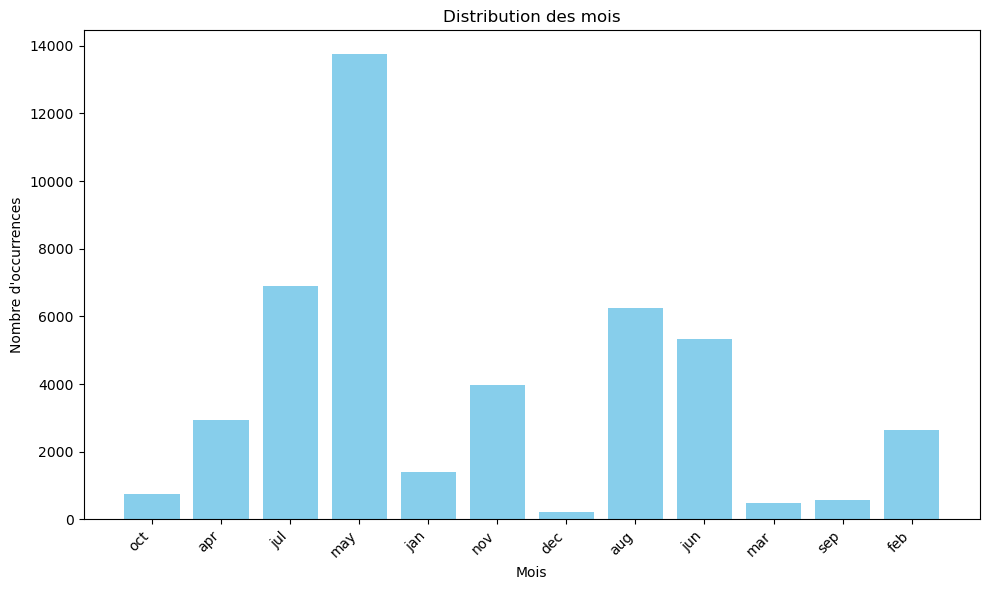

In [71]:
import matplotlib.pyplot as plt
query = """
    SELECT month, COUNT(*) AS month_occurrences
    FROM bank_full
    GROUP BY month;
    
"""
cur.execute(query)

results = cur.fetchall()

months = [result[0] for result in results]
occurrences = [result[1] for result in results]

plt.figure(figsize=(10, 6))
plt.bar(months, occurrences, color='skyblue')
plt.title('Distribution des mois')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#la plupart des gens ont été contacté précédemment en mai.

### 8:  What is the average duration of contact for customers who have a personal loan?

In [72]:
query = """
    SELECT AVG(duration) AS average_duration
    FROM bank_full
    WHERE loan = 'yes';
"""
cur.execute(query)

average_duration = cur.fetchone()[0]
print("Durée moyenne de contacts pour les clients ayant un prêt :", average_duration)

Durée moyenne de contacts pour les clients ayant un prêt : 250.8453892876863611


### 9: How many customers were previously contacted, and what was the average duration of their last contact?

In [74]:
query = """
    SELECT COUNT(*) AS num_clients, AVG(duration) AS avg_duration
    FROM bank_full
    WHERE previous <> 0;
"""
cur.execute(query)
result = cur.fetchone()
num_clients = result[0]
avg_duration = result[1]
print(f"Nombre de clients précédemment contactés : {num_clients}")
print(f"Durée moyenne du contact : {avg_duration} ")

Nombre de clients précédemment contactés : 8257
Durée moyenne du contact : 260.1186871745185903 


### 10: What is the distribution of job types among customers?

Distribution of job types among customers:
Job: blue-collar Count: 9732
Job: management Count: 9458
Job: technician Count: 7597
Job: admin. Count: 5171
Job: services Count: 4154
Job: retired Count: 2264
Job: self-employed Count: 1579
Job: entrepreneur Count: 1487
Job: unemployed Count: 1303
Job: housemaid Count: 1240
Job: student Count: 938
Job: unknown Count: 288


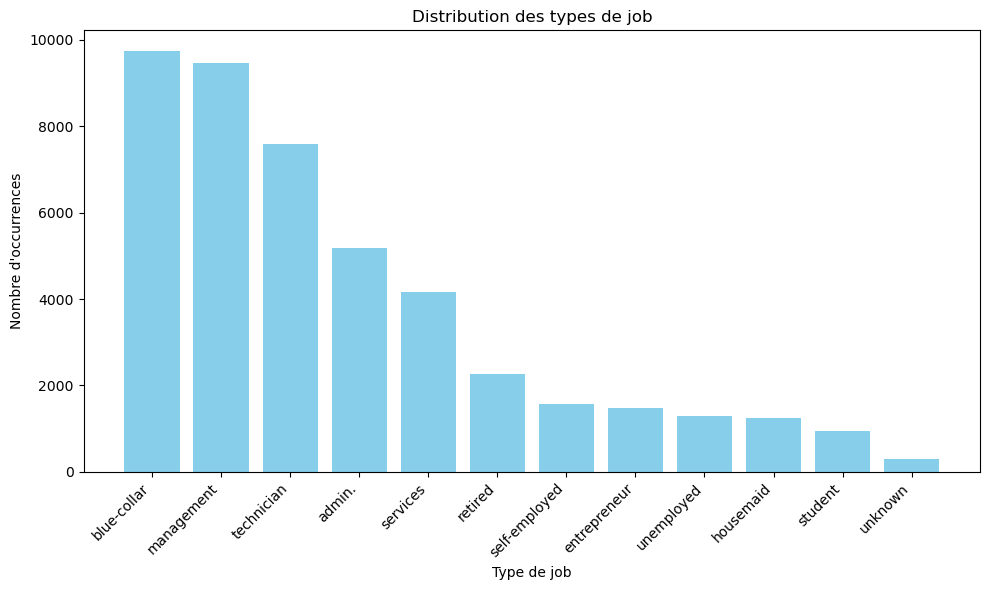

In [20]:
import matplotlib.pyplot as plt
query = """
    SELECT job, COUNT(*) AS job_count
    FROM bank_full
    GROUP BY job
    ORDER BY job_count DESC;
"""
cur.execute(query)
results = cur.fetchall()
jobs = [row[0] for row in results]
job_counts = [row[1] for row in results]

print("Distribution of job types among customers:")
for result in results:
    print("Job:", result[0], "Count:", result[1])
conn.commit()
plt.figure(figsize=(10, 6))
plt.bar(jobs, job_counts, color='skyblue')
plt.title('Distribution des types de job')
plt.xlabel('Type de job')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 11: How many customers have been contacted more than once in the current campaign?

In [76]:
query = """
    SELECT COUNT(*) AS num_clients_contactes
    FROM bank_full
    WHERE campaign > 1;
"""
cur.execute(query)
num_clients_contactes = cur.fetchone()[0]
print(f"Nombre de clients contactés plus d'une fois dans cette campagne : {num_clients_contactes}")


Nombre de clients contactés plus d'une fois dans cette campagne : 27667


### 12: What is the success rate of previous marketing campaigns (poutcome) among customers?

In [89]:

conn = psycopg2.connect(dbname="new_db", user="postgres", password="root", host="localhost",  port="5432" )
cur = conn.cursor()
query_success = """
    SELECT COUNT(*) AS success_count
    FROM bank_full
    WHERE poutcome = 'success';
"""
cur.execute(query_success)
success_count = cur.fetchone()[0]
query_total = """
    SELECT COUNT(*) AS total_count
    FROM bank_full;

"""
cur.execute(query_total)
total_count = cur.fetchone()[0]
success_rate = (success_count / total_count) * 100
print(f"Taux de succès des campagnes précédentes : {success_rate:.2f}%")

Taux de succès des campagnes précédentes : 3.34%
